In [1]:
import os
import kagglehub
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Import training functions from train.py
from train import train_model, plot_metrics

# Download latest version of the dataset from Kaggle
path = kagglehub.dataset_download("tongpython/cat-and-dog")


### Create train and test datset with dataloader

In [2]:
# Set subclass of Dataset for kaggle Dataset
class PetDataSet(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes
    
# Set paths to training and test folders with classes as subdirs
train_folder = os.path.join(path, "training_set/training_set")
test_folder = os.path.join(path, "test_set/test_set")

# Get a dictionary associating target values with folder names
target_to_class = {v: k for k, v in ImageFolder(train_folder).class_to_idx.items()}
print("Classes found:", target_to_class)

# Define transformations and create DataLoaders
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset = PetDataSet(train_folder, transform=transform)
test_dataset = PetDataSet(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Classes found: {0: 'cats', 1: 'dogs'}


### Train pretrained model

------------------ Starting epoch 1 of 10 ------------------


Testing loop: 100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


New highest accuracy: 0.9377162629757786, saving model...
Train loss: 0.344753783071957, Test loss: 0.16044297512368405, Accuracy: 0.9377162629757786
------------------ Starting epoch 2 of 10 ------------------


Testing loop: 100%|██████████| 32/32 [00:06<00:00,  4.60it/s]


New highest accuracy: 0.953534354918438, saving model...
Train loss: 0.16422910667644078, Test loss: 0.12830605895962388, Accuracy: 0.953534354918438
------------------ Starting epoch 3 of 10 ------------------


Testing loop: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


Train loss: 0.15244392467096105, Test loss: 0.19745216433196391, Accuracy: 0.9164607019278299
------------------ Starting epoch 4 of 10 ------------------


Testing loop: 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]


Train loss: 0.18221599652125342, Test loss: 0.16278062638924726, Accuracy: 0.9357390014829461
------------------ Starting epoch 5 of 10 ------------------


Testing loop: 100%|██████████| 32/32 [00:07<00:00,  4.40it/s]


Train loss: 0.1230657589893502, Test loss: 0.12706506934736958, Accuracy: 0.9480968858131488
------------------ Starting epoch 6 of 10 ------------------


Testing loop: 100%|██████████| 32/32 [00:07<00:00,  4.28it/s]


Train loss: 0.0966678438647688, Test loss: 0.13513077720005326, Accuracy: 0.9446366782006921
------------------ Starting epoch 7 of 10 ------------------


Testing loop: 100%|██████████| 32/32 [00:07<00:00,  4.45it/s]


New highest accuracy: 0.9683638161146811, saving model...
Train loss: 0.09270923130597708, Test loss: 0.08475573227229356, Accuracy: 0.9683638161146811
------------------ Starting epoch 8 of 10 ------------------


Testing loop: 100%|██████████| 32/32 [00:07<00:00,  4.55it/s]


Train loss: 0.0984001154611719, Test loss: 0.13932531549090274, Accuracy: 0.9461196243203164
------------------ Starting epoch 9 of 10 ------------------


Testing loop: 100%|██████████| 32/32 [00:07<00:00,  4.00it/s]


Train loss: 0.08366280552151052, Test loss: 0.1140795640842607, Accuracy: 0.9574888779041029
------------------ Starting epoch 10 of 10 ------------------


Testing loop: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]


Train loss: 0.21744976765397636, Test loss: 0.1915833149206591, Accuracy: 0.9204152249134948


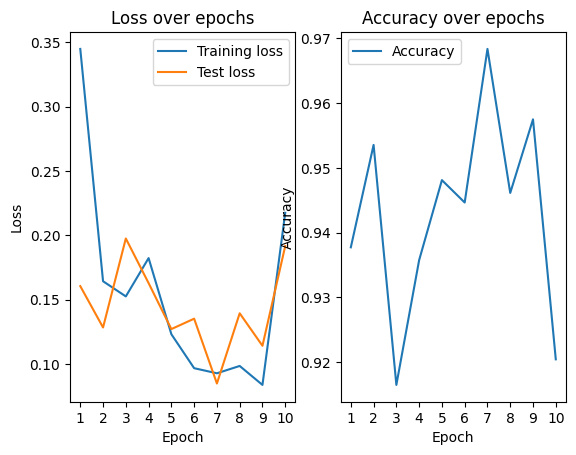

<Figure size 1500x500 with 0 Axes>

In [3]:
train_losses, test_losses, accuracies = train_model(train_loader, 
                                                    test_loader,
                                                    num_epochs=10, 
                                                    learning_rate=0.001, 
                                                    model_name="pretrained_classifier",
                                                    pretrained=True,
                                                    use_LR_scheduler=True)
plot_metrics(train_losses, test_losses, accuracies)

## Train model from scratch

In [ ]:
train_losses, test_losses, accuracies = train_model(train_loader, 
                                                    test_loader, 
                                                    num_epochs=25, 
                                                    learning_rate=0.001, 
                                                    model_name="scratch_classifier", 
                                                    pretrained=False,
                                                    use_LR_scheduler=True)
plot_metrics(train_losses, test_losses, accuracies)

------------------ Starting epoch 1 of 25 ------------------


Testing loop: 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]


New highest accuracy: 0.6055363321799307, saving model...
Train loss: 0.6830947586478925, Test loss: 0.6715059892057607, Accuracy: 0.6055363321799307
------------------ Starting epoch 2 of 25 ------------------


Testing loop: 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]


Train loss: 0.6666521381989335, Test loss: 0.7285782179794745, Accuracy: 0.583292140385566
------------------ Starting epoch 3 of 25 ------------------


Testing loop: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


New highest accuracy: 0.6386554621848739, saving model...
Train loss: 0.6407011043422302, Test loss: 0.6259839941503031, Accuracy: 0.6386554621848739
------------------ Starting epoch 4 of 25 ------------------


Testing loop: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


New highest accuracy: 0.6742461690558577, saving model...
Train loss: 0.6150150036603342, Test loss: 0.6031097607982672, Accuracy: 0.6742461690558577
------------------ Starting epoch 5 of 25 ------------------


Testing loop: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]


Train loss: 0.5955587283958873, Test loss: 0.6022417635771524, Accuracy: 0.6599110232328226
------------------ Starting epoch 6 of 25 ------------------


Testing loop: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s]


New highest accuracy: 0.6930301532377657, saving model...
Train loss: 0.5804958650426966, Test loss: 0.5773261351804596, Accuracy: 0.6930301532377657
------------------ Starting epoch 7 of 25 ------------------


Training loop:  29%|██▊       | 36/126 [00:13<00:34,  2.59it/s]